# Identify Covid-19 epidemic episodes in national time series

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from detecta import detect_onset
import numpy as np
import seaborn as sns

## Loading data

In [53]:
df_ts_sample = pd.read_csv('data/output/df_national.csv', index_col=0)
df_ts_sample.DATA = pd.to_datetime(df_ts_sample.DATA, infer_datetime_format=True)

In [54]:
df_ts_sample = df_ts_sample.sort_values(['DATA'])

In [55]:
df_ts_sample.columns

Index(['DATA', 'OBITOS_NOVOS_PAINEL', 'OBITOS_ACUMULADO_PAINEL',
       'CASOS_NOVOS_PAINEL', 'CASOS_ACUMULADO_PAINEL', 'day_of_week',
       'CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL',
       'OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL', 'OBITOS_NOVOS_SIM',
       'OBITOS_ACUMULADO_SIM', 'OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_SIM',
       'POPULACAO_2022', 'TAXA_OBITOS_NOVOS_SIM',
       'TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_SIM', 'TAXA_OBITOS_SIM',
       'NOVOS_CASOS_SRAG', 'NOVOS_OBITOS_SRAG',
       'CASOS_INICIO_SINTOMAS_ESTIMADOS', 'NUMERO_REPRODUCAO_EFETIVO_MEDIA',
       'NUMERO_REPRODUCAO_EFETIVO_VARIANCIA',
       'NUMERO_REPRODUCAO_EFETIVO_QUANTIL_0.025',
       'NUMERO_REPRODUCAO_EFETIVO_MEDIANA',
       'NUMERO_REPRODUCAO_EFETIVO_QUANTIL_0.975',
       'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIA',
       'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_VARIANCIA',
       'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_QUANTIL_0.025',
       'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIANA',
       'NUMERO_REPRODUCAO

In [56]:
df_ts_other_countries = pd.read_csv('data/output/df_ts_other_countries_epidemic_parameters.csv')
df_ts_other_countries.date = pd.to_datetime(df_ts_other_countries.date)

In [57]:
df_ts_other_countries.head()

,Unnamed: 0,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,rate_new_cases_moving_average,new_cases_moving_average,estimated_cases_by_deaths,estimated_onset_by_deaths,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIA,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_VARIANCIA,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_QUANTIL_0.025,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIANA,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_QUANTIL_0.975,TAXA_FATALIDADE
0,0,BEL,Europe,Belgium,2020-01-03,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,BEL,Europe,Belgium,2020-01-04,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,BEL,Europe,Belgium,2020-01-05,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,BEL,Europe,Belgium,2020-01-06,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,BEL,Europe,Belgium,2020-01-07,NaN,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
df_ts_other_countries.columns

Index(['Unnamed: 0', 'iso_code', 'continent', 'location', 'date',
       'total_cases', 'new_cases', 'new_cases_smoothed', 'total_deaths',
       'new_deaths', 'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smooth

In [59]:
df_ts_other_countries.shape

(9846, 82)

In [60]:
df_ts_other_countries.location.unique()

array(['Belgium', 'Denmark', 'Hungary', 'Luxembourg', 'Norway',
       'Portugal', 'Spain', 'United Kingdom', 'United States'],
      dtype=object)

In [61]:
df_ts_other_countries = df_ts_other_countries[df_ts_other_countries.date <= df_ts_sample.DATA.max()]
df_ts_other_countries

,Unnamed: 0,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,rate_new_cases_moving_average,new_cases_moving_average,estimated_cases_by_deaths,estimated_onset_by_deaths,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIA,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_VARIANCIA,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_QUANTIL_0.025,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIANA,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_QUANTIL_0.975,TAXA_FATALIDADE
0,0,BEL,Europe,Belgium,2020-01-03,NaN,0.0,NaN,NaN,0.0,...,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,BEL,Europe,Belgium,2020-01-04,NaN,0.0,NaN,NaN,0.0,...,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,BEL,Europe,Belgium,2020-01-05,NaN,0.0,NaN,NaN,0.0,...,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,3,BEL,Europe,Belgium,2020-01-06,NaN,0.0,NaN,NaN,0.0,...,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,4,BEL,Europe,Belgium,2020-01-07,NaN,0.0,NaN,NaN,0.0,...,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9841,1089,USA,North America,United States,2022-12-27,99019493.0,0.0,72572.714,1079976.0,0.0,...,21.452820,72572.714286,39703.148338,NaN,NaN,NaN,NaN,NaN,NaN,1.002317
9842,1090,USA,North America,United States,2022-12-28,99019493.0,0.0,72572.714,1079976.0,0.0,...,21.452820,72572.714286,39703.148338,NaN,NaN,NaN,NaN,NaN,NaN,0.656177
9843,1091,USA,North America,United States,2022-12-29,99019493.0,0.0,72572.714,1079976.0,0.0,...,21.452820,72572.714286,39703.148338,NaN,NaN,NaN,NaN,NaN,NaN,0.656177
9844,1092,USA,North America,United States,2022-12-30,99411696.0,392203.0,56029.000,1082456.0,2480.0,...,16.562424,56029.000000,32464.163494,NaN,NaN,NaN,NaN,NaN,NaN,0.536538


## Identifying epidemic episodes

In [62]:
def detect_onset_deaths(death_series, onset_rt):
    onset_deaths = np.empty((0, 2))
    
    plt.plot(death_series)
    
    for i in range(len(onset_rt)):
        onset_rt_begin = onset_rt[i][0]
        onset_rt_end = onset_rt[i][1]
        
        # death_threshold = np.mean(death_series[onset_rt_begin: onset_rt_end]) * 1.17
        death_threshold = np.mean(death_series[onset_rt_begin: onset_rt_end]) * 1
                
        for onset_deaths_end in range(onset_rt_end+1,len(death_series)):
            if death_series[onset_deaths_end] <= death_threshold:
                break
        onset_deaths = np.append(onset_deaths, np.array([[onset_rt_end, onset_deaths_end]]), axis=0)
        
        plt.axvspan(onset_rt_end, onset_deaths_end, color='red', alpha=0.25, label='Onset Period')
        plt.axvline(x=onset_rt_begin,color='green')        
        plt.axvline(x=onset_rt_end,color='blue')
        plt.scatter(x=onset_rt_end, y=death_threshold, color='black')

    return onset_deaths            

### Brazil

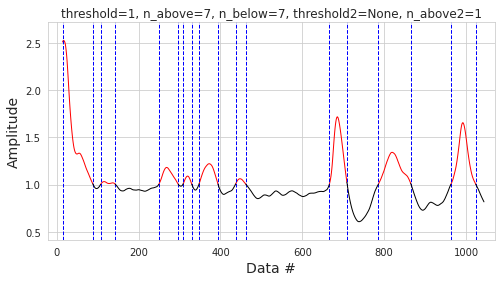

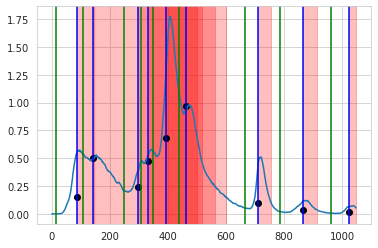

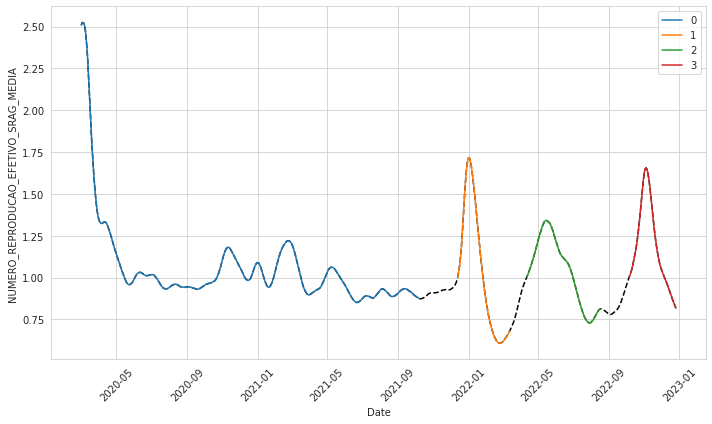

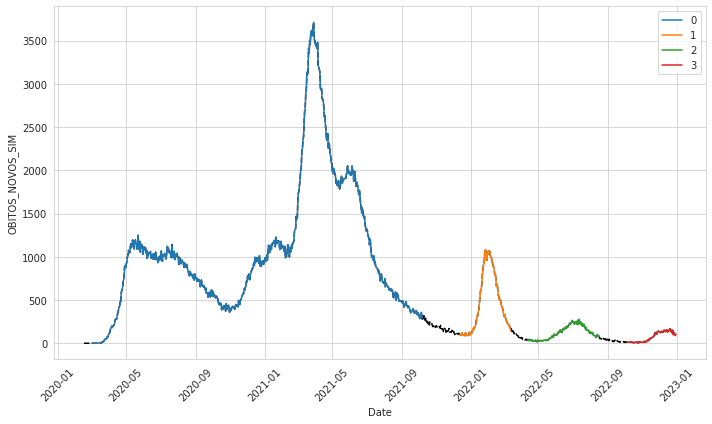

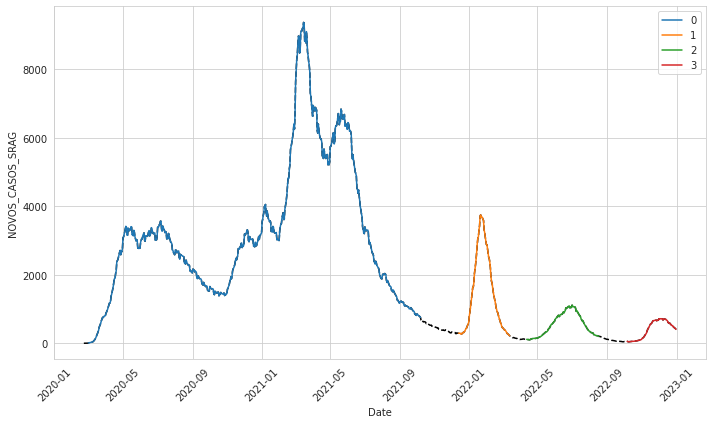

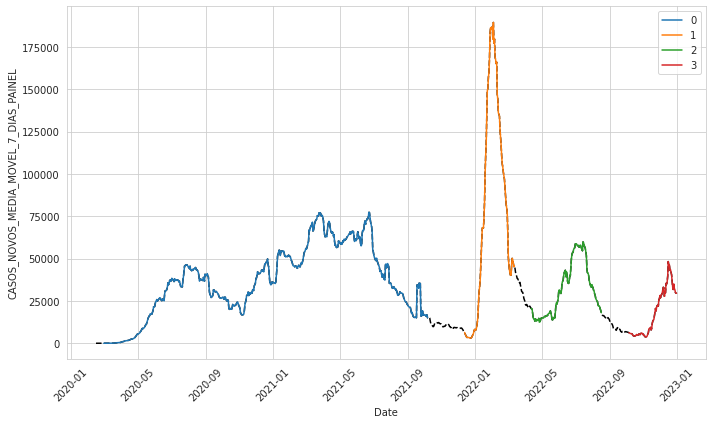

In [63]:
df_ts_epidemic_episodes = pd.DataFrame()

onset_rt = detect_onset(df_ts_sample.NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA, threshold=1, n_above=7, n_below=7, show=True)
# onset_rt = detect_onset(df_ts_sample.NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA, threshold=1, n_above=21, n_below=7, show=True)
plt.show()

onset_deaths = detect_onset_deaths(df_ts_sample.TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_SIM.values, onset_rt)
plt.show()

epidemic_episodes = np.empty((0, 2))

for i in range(len(onset_rt)):
    onset_rt_begin = onset_rt[i][0]
    onset_rt_end = onset_rt[i][1]
    days_onset_rt = onset_rt_end - onset_rt_begin
   
    onset_deaths_i = onset_deaths[(onset_deaths[:,0]>onset_rt_begin) & (onset_deaths[:,0]<=onset_rt_end)]
       
    onset_deaths_end = onset_deaths_i[-1][1]
    outbreak_end = onset_deaths_end                  
    
    outbreak_begin = onset_rt_begin    
    outbreak = [outbreak_begin, outbreak_end]
    epidemic_episodes = np.append(epidemic_episodes, [outbreak], axis=0)    
    
# Initialize the merged_outbreaks array with the first period from outbreaks
merged_epidemic_episodes = [epidemic_episodes[0]]

# Iterate through the rest of the outbreaks to merge contiguous periods
for period in epidemic_episodes[1:]:
    last_merged_period = merged_epidemic_episodes[-1]
    
    if period[0] <= last_merged_period[1]:
        # Merge contiguous periods by updating the end time of the last merged period
        merged_epidemic_episodes[-1][1] = max(period[1], last_merged_period[1])
    else:
        # Append the non-contiguous period to the merged_outbreaks array
        merged_epidemic_episodes.append(period)

# Convert the merged_outbreaks list to a numpy array
merged_epidemic_episodes = np.array(merged_epidemic_episodes)

for i in range(len(merged_epidemic_episodes)):
    df_ts_sample.loc[merged_epidemic_episodes[i][0]:merged_epidemic_episodes[i][1], 'EPIDEMIC_EPISODE'] = str(i)
for i in range(len(onset_rt)):
    df_ts_sample.loc[onset_rt[i][0]:onset_rt[i][1],'ONSET_NUMERO_REPRODUCAO_EFETIVO_MEDIA'] = str(i)
for i in range(len(onset_deaths)):
    df_ts_sample.loc[onset_deaths[i][0]:onset_deaths[i][1],'ONSET_TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS'] = str(i)    

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot the time series with different line colors for each outbreak
sns.lineplot(data=df_ts_sample, x='DATA', y='NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA', color='black', linestyle='--')
sns.lineplot(data=df_ts_sample, x='DATA', y='NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA', hue='EPIDEMIC_EPISODE')

# Add title and labels
plt.xlabel("Date")
plt.ylabel("NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot the time series with different line colors for each outbreak
sns.lineplot(data=df_ts_sample, x='DATA', y='OBITOS_NOVOS_SIM', color='black', linestyle='--')
sns.lineplot(data=df_ts_sample, x='DATA', y='OBITOS_NOVOS_SIM', hue='EPIDEMIC_EPISODE')

# Add title and labels
plt.xlabel("Date")
plt.ylabel("OBITOS_NOVOS_SIM")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot the time series with different line colors for each outbreak
sns.lineplot(data=df_ts_sample, x='DATA', y=df_ts_sample['NOVOS_CASOS_SRAG'].rolling(7,min_periods=7).mean(), color='black', linestyle='--')
sns.lineplot(data=df_ts_sample, x='DATA', y=df_ts_sample['NOVOS_CASOS_SRAG'].rolling(7,min_periods=7).mean(), hue='EPIDEMIC_EPISODE')

# Add title and labels
plt.xlabel("Date")
plt.ylabel("NOVOS_CASOS_SRAG")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot the time series with different line colors for each outbreak
sns.lineplot(data=df_ts_sample, x='DATA', y='CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL', color='black', linestyle='--')
sns.lineplot(data=df_ts_sample, x='DATA', y='CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL', hue='EPIDEMIC_EPISODE')

# Add title and labels
plt.xlabel("Date")
plt.ylabel("CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

df_ts_epidemic_episodes = df_ts_epidemic_episodes.append(df_ts_sample, ignore_index=True)

### Other countries

Belgium


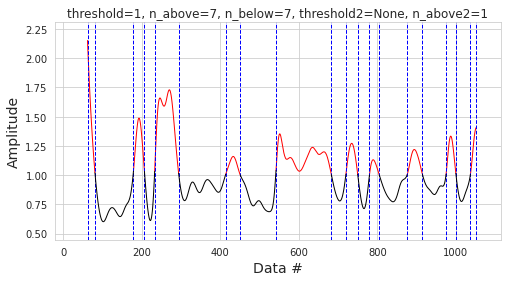

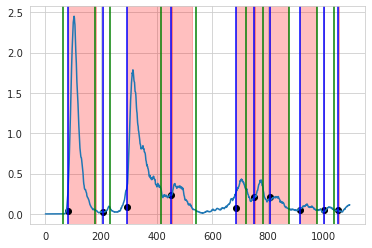

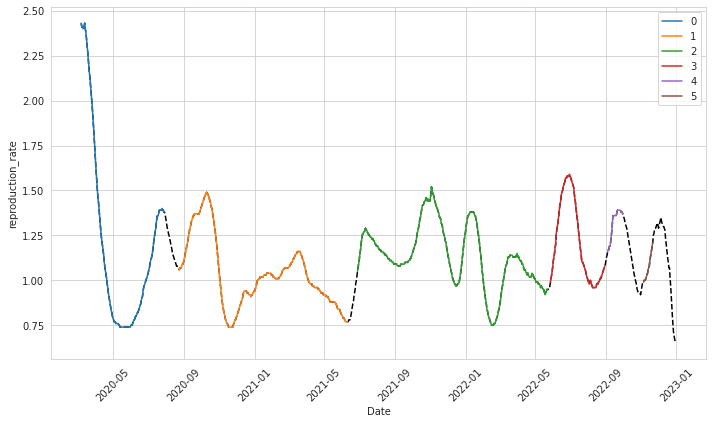

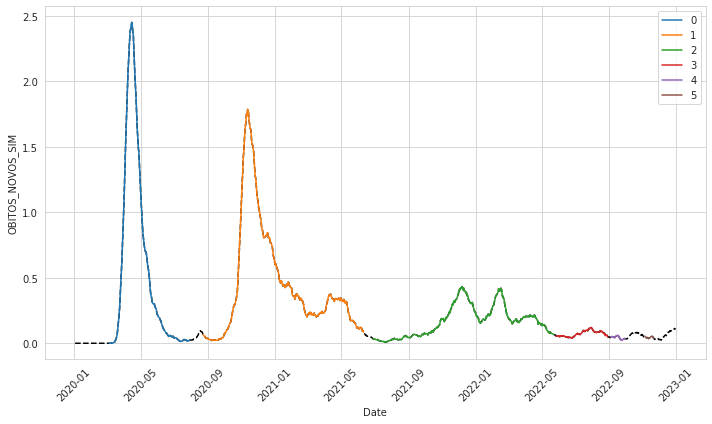

Denmark


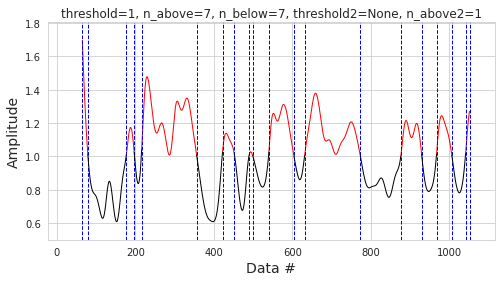

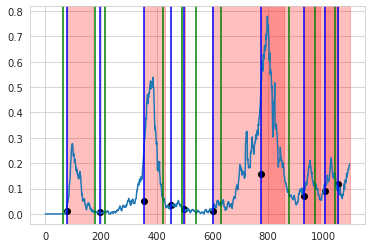

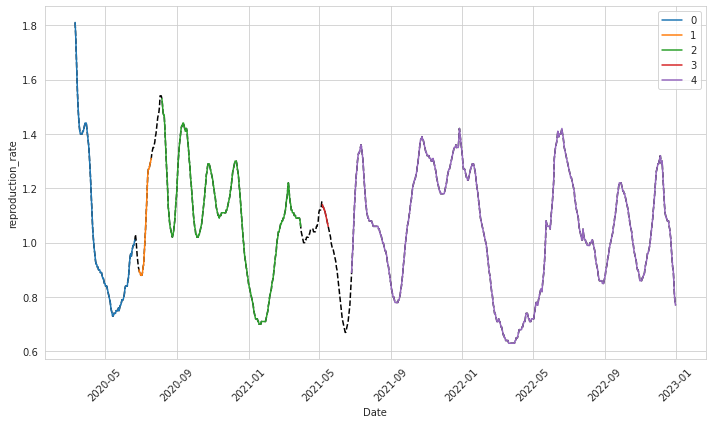

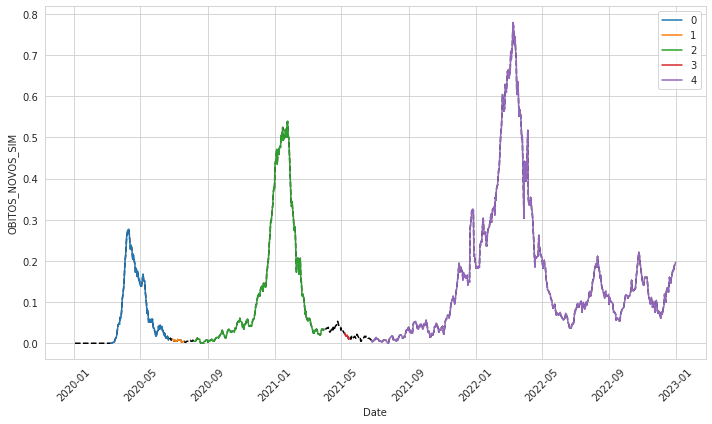

Hungary


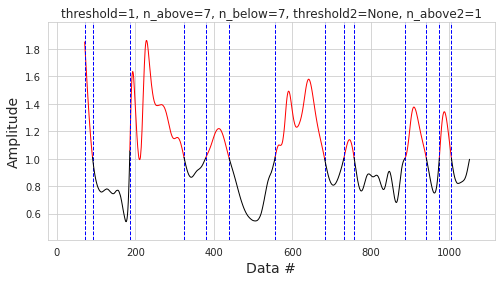

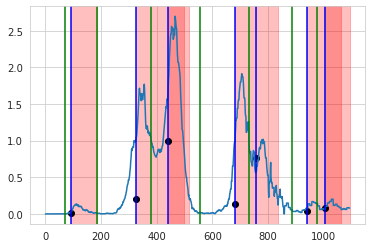

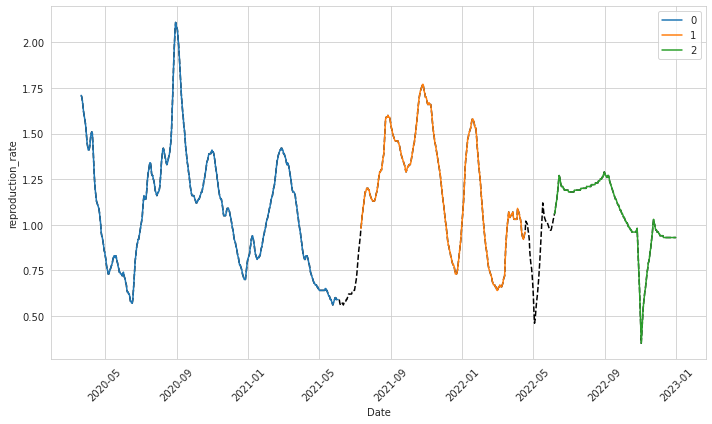

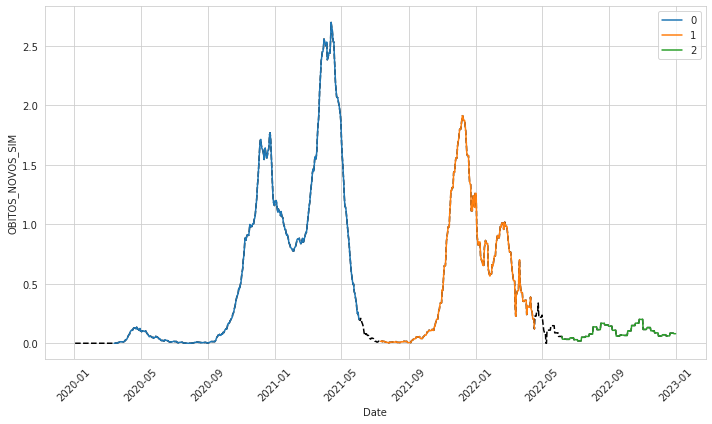

Luxembourg


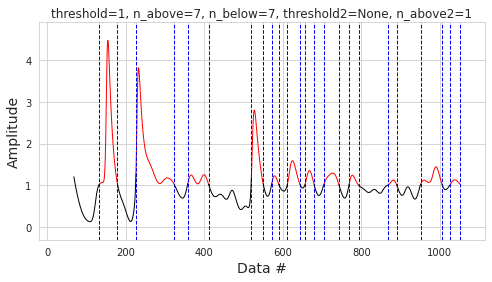

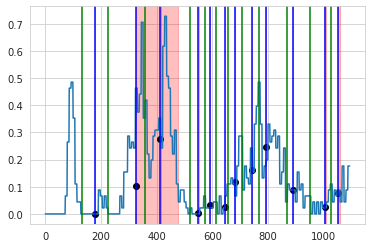

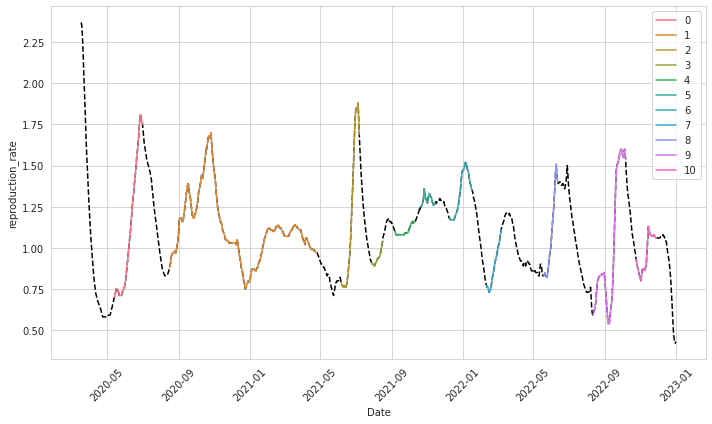

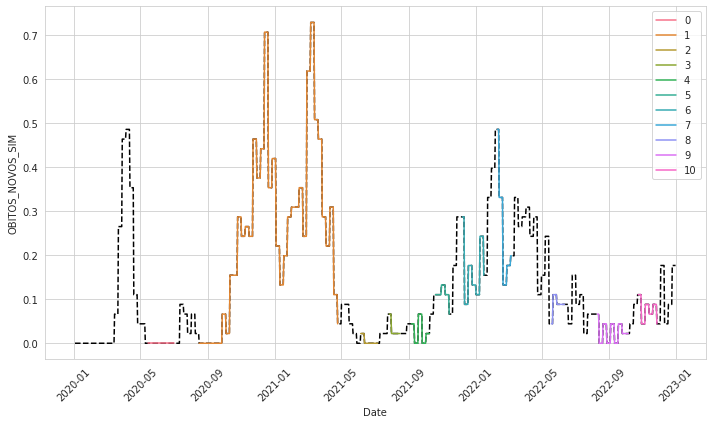

Norway


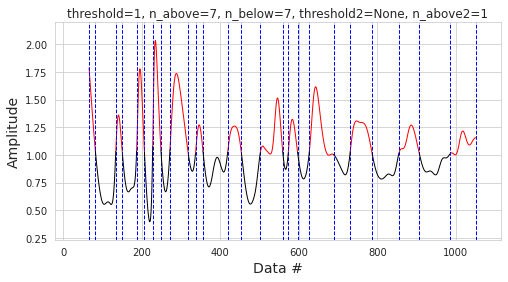

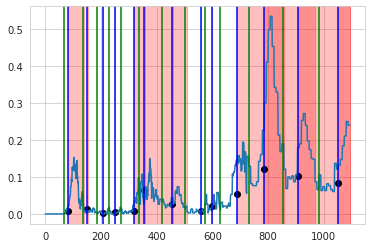

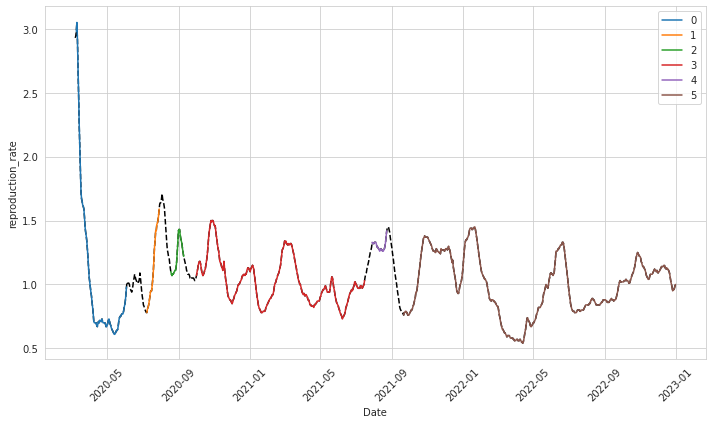

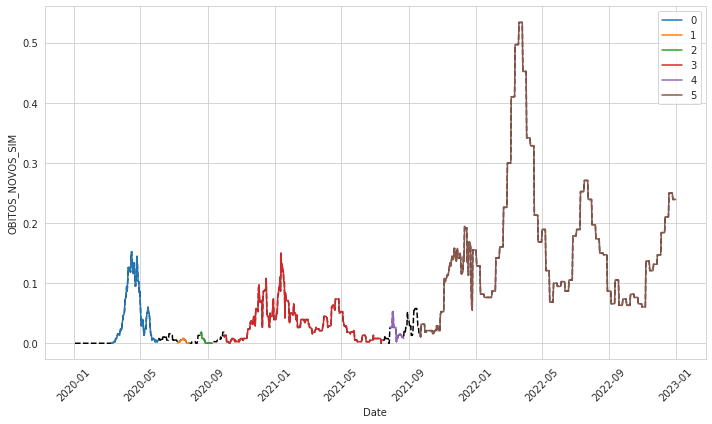

Portugal


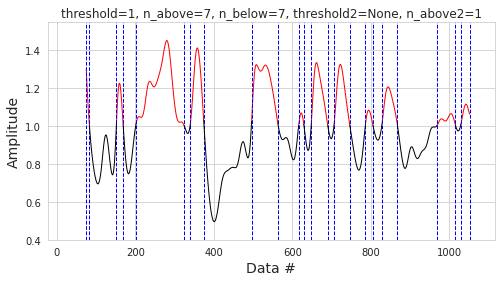

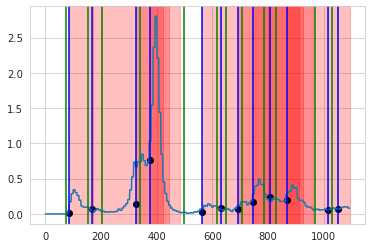

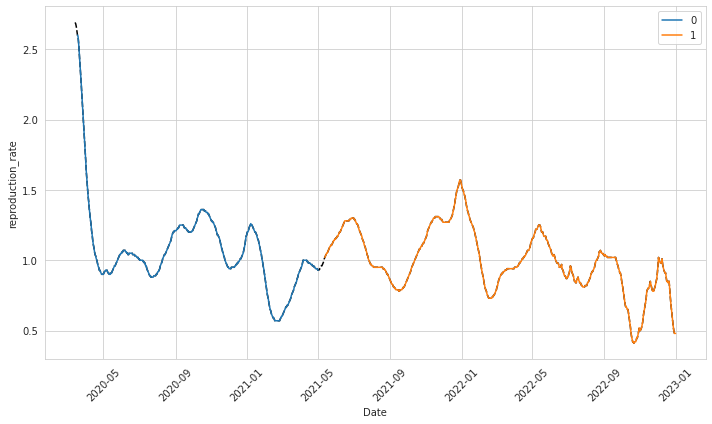

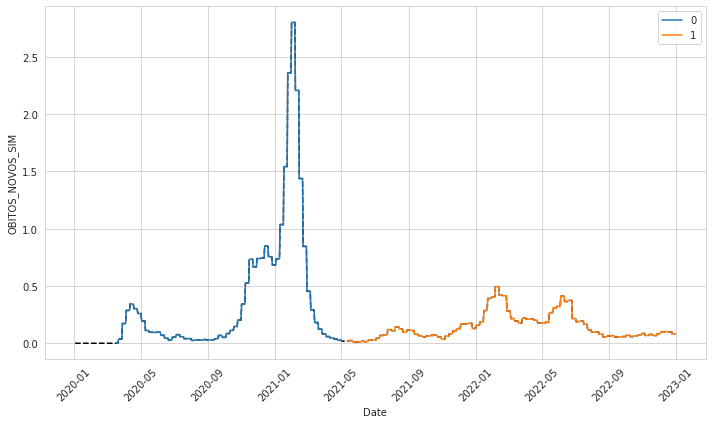

Spain


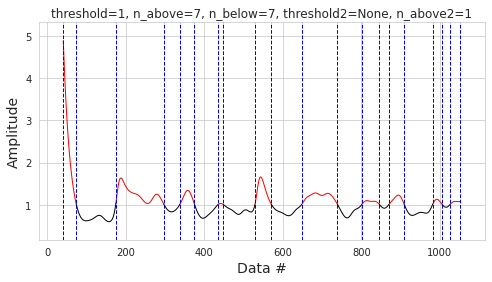

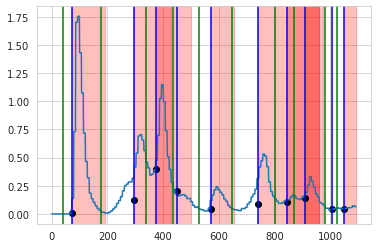

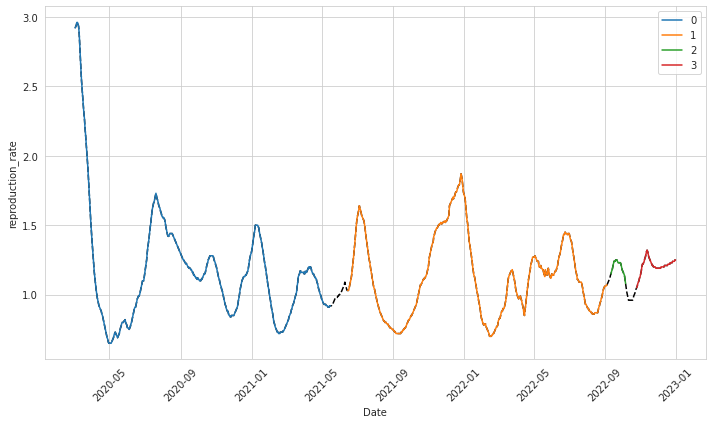

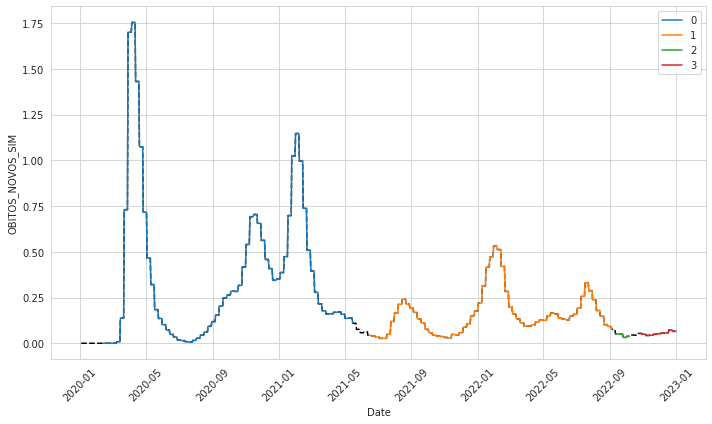

United Kingdom


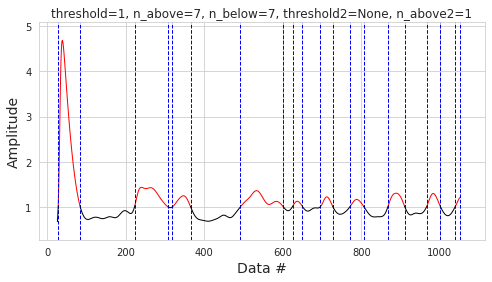

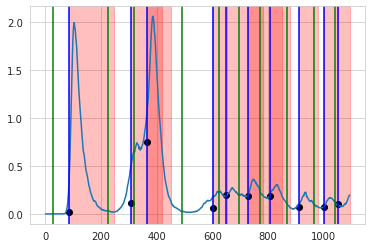

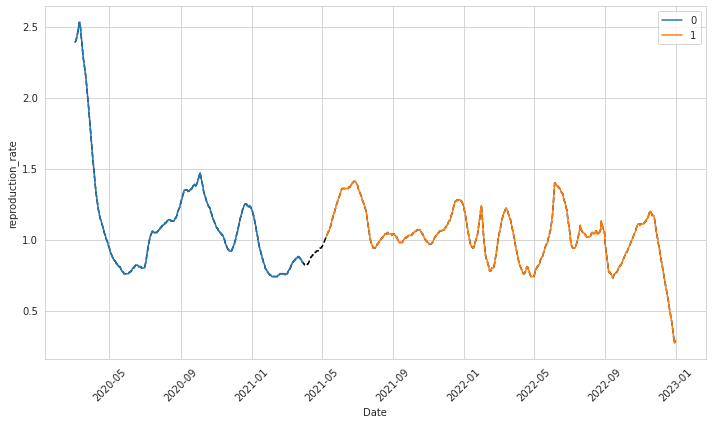

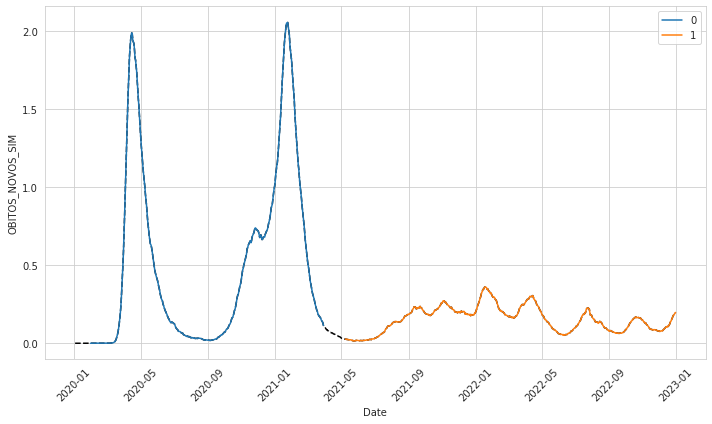

United States


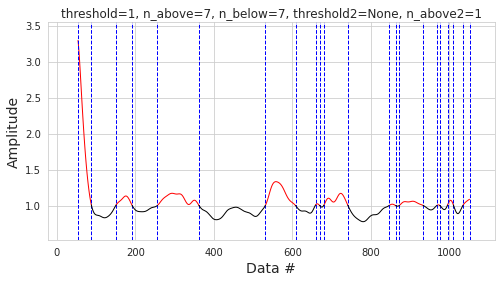

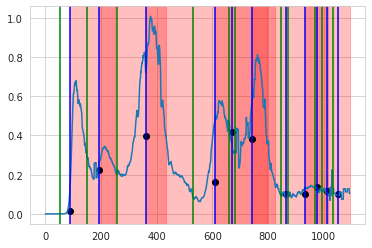

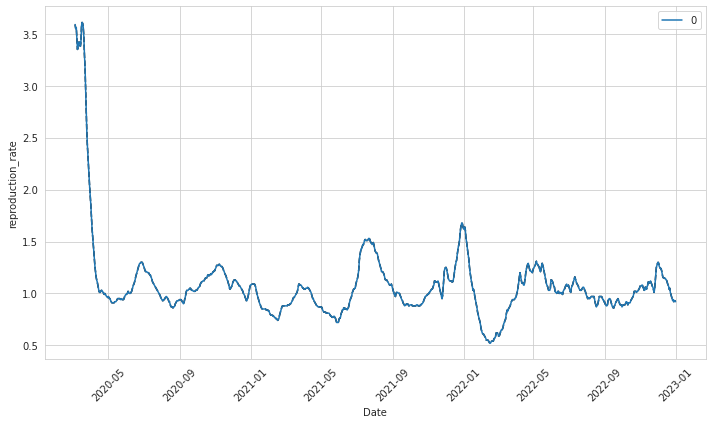

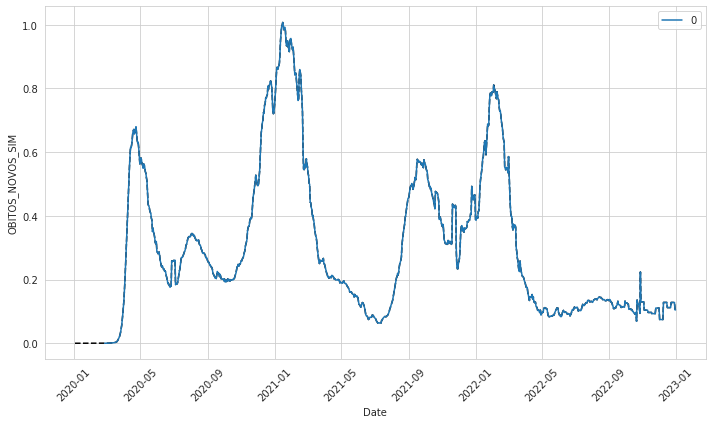

In [64]:
RT_COLUMN = 'NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIA'
# RT_COLUMN = 'reproduction_rate'

df_ts_epidemic_episodes_other_countries = pd.DataFrame()

for location in df_ts_other_countries.location.unique():
    print(location)
    df_temp = df_ts_other_countries[df_ts_other_countries.location == location]
    df_temp = df_temp.reset_index(drop=True)

    # onset_rt = detect_onset(df_temp[RT_COLUMN], threshold=1, n_above=21, n_below=7, show=True)
    onset_rt = detect_onset(df_temp[RT_COLUMN], threshold=1, n_above=7, n_below=7, show=True)
    plt.show()
    
    # onset_deaths = detect_onset_deaths(df_temp.rate_new_deaths_moving_average.values, onset_rt)
    onset_deaths = detect_onset_deaths(df_temp.rate_new_deaths_moving_average.values, onset_rt)
    plt.show()
    
    epidemic_episodes = np.empty((0, 2))
    
    for i in range(len(onset_rt)):
        onset_rt_begin = onset_rt[i][0]
        onset_rt_end = onset_rt[i][1]
        days_onset_rt = onset_rt_end - onset_rt_begin
       
        onset_deaths_i = onset_deaths[(onset_deaths[:,0]>onset_rt_begin) & (onset_deaths[:,0]<=onset_rt_end)]
           
        onset_deaths_end = onset_deaths_i[-1][1]
        outbreak_end = onset_deaths_end                  
        
        outbreak_begin = onset_rt_begin
        outbreak = [outbreak_begin, outbreak_end]
        epidemic_episodes = np.append(epidemic_episodes, [outbreak], axis=0)    
        
    # Initialize the merged_outbreaks array with the first period from outbreaks
    merged_epidemic_episodes = [epidemic_episodes[0]]
    
    # Iterate through the rest of the outbreaks to merge contiguous periods
    for period in epidemic_episodes[1:]:
        last_merged_period = merged_epidemic_episodes[-1]
        
        if period[0] <= last_merged_period[1]:
            # Merge contiguous periods by updating the end time of the last merged period
            merged_epidemic_episodes[-1][1] = max(period[1], last_merged_period[1])
        else:
            # Append the non-contiguous period to the merged_outbreaks array
            merged_epidemic_episodes.append(period)
    
    # Convert the merged_outbreaks list to a numpy array
    merged_epidemic_episodes = np.array(merged_epidemic_episodes)
    
    for i in range(len(merged_epidemic_episodes)):
        df_temp.loc[merged_epidemic_episodes[i][0]:merged_epidemic_episodes[i][1], 'EPIDEMIC_EPISODE'] = str(i)
    for i in range(len(onset_rt)):
        df_temp.loc[onset_rt[i][0]:onset_rt[i][1],'ONSET_NUMERO_REPRODUCAO_EFETIVO_MEDIA'] = str(i)
    for i in range(len(onset_deaths)):
        df_temp.loc[onset_deaths[i][0]:onset_deaths[i][1],'ONSET_TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS'] = str(i)    
    
    # Initialize the plot
    plt.figure(figsize=(10, 6))
    
    # Plot the time series with different line colors for each outbreak
    sns.lineplot(data=df_temp, x='date', y='reproduction_rate', color='black', linestyle='--')
    sns.lineplot(data=df_temp, x='date', y='reproduction_rate', hue='EPIDEMIC_EPISODE')
    
    # Add title and labels
    plt.xlabel("Date")
    plt.ylabel("reproduction_rate")
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Display the legend
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    # Initialize the plot
    plt.figure(figsize=(10, 6))
    
    # Plot the time series with different line colors for each outbreak
    sns.lineplot(data=df_temp, x='date', y='rate_new_deaths_moving_average', color='black', linestyle='--')
    sns.lineplot(data=df_temp, x='date', y='rate_new_deaths_moving_average', hue='EPIDEMIC_EPISODE')
    
    # Add title and labels
    plt.xlabel("Date")
    plt.ylabel("OBITOS_NOVOS_SIM")
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Display the legend
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()
    
    df_ts_epidemic_episodes_other_countries = df_ts_epidemic_episodes_other_countries.append(df_temp, ignore_index=True)

## Saving data

In [65]:
df_ts_epidemic_episodes.to_csv('data/output/df_ts_epidemic_episodes.csv')

In [66]:
df_ts_epidemic_episodes_other_countries.to_csv('data/output/df_ts_epidemic_episodes_other_countries.csv')

In [67]:
df_ts_epidemic_episodes.head()

,DATA,OBITOS_NOVOS_PAINEL,OBITOS_ACUMULADO_PAINEL,CASOS_NOVOS_PAINEL,CASOS_ACUMULADO_PAINEL,day_of_week,CASOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL,OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS_PAINEL,OBITOS_NOVOS_SIM,OBITOS_ACUMULADO_SIM,...,NUMERO_REPRODUCAO_EFETIVO_SRAG_QUANTIL_0.025,NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIANA,NUMERO_REPRODUCAO_EFETIVO_SRAG_QUANTIL_0.975,TAXA_FATALIDADE,TAXA_FATALIDADE_SRAG,NOVOS_OBITOS_MEDIA_MOVEL_7_DIAS_SRAG,NOVOS_CASOS_MEDIA_MOVEL_7_DIAS_SRAG,EPIDEMIC_EPISODE,ONSET_NUMERO_REPRODUCAO_EFETIVO_MEDIA,ONSET_TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS
0,2020-02-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,5.000000,NaN,NaN,NaN
1,2020-02-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,7.500000,NaN,NaN,NaN
2,2020-02-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,7.666667,NaN,NaN,NaN
3,2020-02-19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,7.000000,NaN,NaN,NaN
4,2020-02-20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,0.0,7.000000,NaN,NaN,NaN


In [68]:
df_ts_epidemic_episodes_other_countries.head()

,Unnamed: 0,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,estimated_onset_by_deaths,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIA,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_VARIANCIA,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_QUANTIL_0.025,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_MEDIANA,NUMERO_REPRODUCAO_EFETIVO_ATRASADO_QUANTIL_0.975,TAXA_FATALIDADE,EPIDEMIC_EPISODE,ONSET_NUMERO_REPRODUCAO_EFETIVO_MEDIA,ONSET_TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS
0,0,BEL,Europe,Belgium,2020-01-03,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,BEL,Europe,Belgium,2020-01-04,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,BEL,Europe,Belgium,2020-01-05,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,BEL,Europe,Belgium,2020-01-06,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,BEL,Europe,Belgium,2020-01-07,NaN,0.0,NaN,NaN,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
